In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import datetime, time
import numpy as np
from pprint import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
import time

In [2]:
start = time.time()
f = open('tweet_data/tweets_#superbowl.txt')

# Make sure to go back to file head
f_start = f.tell()
f.seek(f_start)

WA = ['Washington', 'WA','Seattle','Kirkland'] #0
MA = ['Massachusetts','MA','Boston'] #1
X = []
y = []
ma_count = 0
wa_count = 0
for line in f.readlines():
    tweet = json.loads(line)
    tloc = tweet['tweet']['user']['location']
    if not any(x in tloc for x in WA) and not any(x in tloc for x in MA):
        continue  
    if any(x in tloc for x in WA):
        wa_count += 1
        text = tweet['tweet']['text']
        X.append(text)
        y.append(0)
    elif any(x in tloc for x in MA):
        ma_count += 1
        text = tweet['tweet']['text']
        X.append(text)
        y.append(1)
print "#superbowl loaded"
print len(X)
print len(y)
print "Finish loading tweets: %s sec"%(time.time() - start)

#superbowl loaded
53593
53593
Finish loading tweets: 459.278976202 sec


In [3]:
print wa_count
print ma_count

30186
23407


### split train/test

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

## TFIDF

In [103]:
# stemming words from the same root
stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip(string.punctuation)
                for token in tokens if token.isalnum()]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# vectorize documents
vectorizer = CountVectorizer(min_df=1, stop_words='english', tokenizer=tokenize_and_stem)

# transform into TFIDF
tfidf_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True)

# lsa
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))

### Naive Bayes

In [104]:
nb_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('scaler', MinMaxScaler()),
                     ('clf', MultinomialNB()),
])

In [105]:
nb_text_clf = nb_text_clf.fit(X_train,y_train)

In [106]:
predicted = nb_text_clf.predict(X_test)
np.mean(predicted == y_test)

0.55928724694467769

In [107]:
print(metrics.classification_report(y_test, predicted,
    target_names=['Washington', 'Massachusetts']))

metrics.confusion_matrix(np.array(y_test), predicted)

               precision    recall  f1-score   support

   Washington       0.56      1.00      0.72      5995
Massachusetts       0.00      0.00      0.00      4724

  avg / total       0.31      0.56      0.40     10719



array([[5995,    0],
       [4724,    0]])

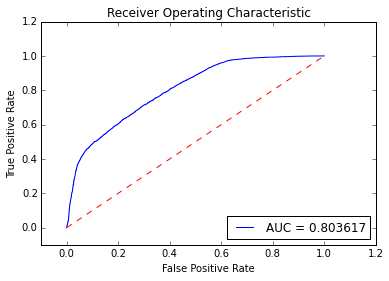

In [108]:
nb_predicted_prob = nb_text_clf.predict_proba(X_test)
# plot ROC curve
nb_fpr, nb_tpr, thresholds = roc_curve(y_test, nb_predicted_prob[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(nb_fpr, nb_tpr, 'b',
label='AUC = %f'% nb_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Linear SVM

In [109]:
from sklearn.svm import SVC
lsvm_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('clf', SVC(kernel='linear')),
])

In [110]:
# train
lsvm_text_clf = lsvm_text_clf.fit(X_train, y_train)

In [111]:
# test
lsvm_decision_function = lsvm_text_clf.decision_function(X_test)
lsvm_predicted = lsvm_text_clf.predict(X_test)

In [112]:
print 'Accuracy:'
print np.mean(lsvm_predicted == y_test)
print(metrics.classification_report(y_test, lsvm_predicted,
    target_names=['Washington', 'Massachusetts']))

metrics.confusion_matrix(y_test, lsvm_predicted)

Accuracy:
0.717231084989
               precision    recall  f1-score   support

   Washington       0.68      0.93      0.79      5995
Massachusetts       0.83      0.45      0.58      4724

  avg / total       0.75      0.72      0.70     10719



array([[5560,  435],
       [2596, 2128]])

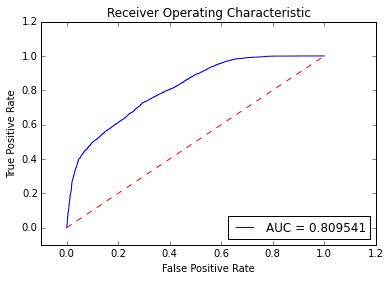

In [113]:
# plot ROC
lsvm_fpr, lsvm_tpr, thresholds = roc_curve(y_test, lsvm_decision_function)
lsvm_roc_auc = auc(lsvm_fpr, lsvm_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(lsvm_fpr, lsvm_tpr, 'b',
label='AUC = %f'% lsvm_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression
lgr_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('clf', LogisticRegression()),
])

In [115]:
lgr_text_clf = lgr_text_clf.fit(X_train, y_train)

In [116]:
# test
lgr_predicted_prob = lgr_text_clf.predict_proba(X_test)[:,1]
lgr_predicted = lgr_text_clf.predict(X_test)

In [117]:
print 'Accuracy:'
print np.mean(lgr_predicted == y_test)
print(metrics.classification_report(y_test, lgr_predicted,
    target_names=['Washington', 'Massachusetts']))

metrics.confusion_matrix(y_test, lgr_predicted)

Accuracy:
0.7257206829
               precision    recall  f1-score   support

   Washington       0.69      0.91      0.79      5995
Massachusetts       0.81      0.49      0.61      4724

  avg / total       0.75      0.73      0.71     10719



array([[5461,  534],
       [2406, 2318]])

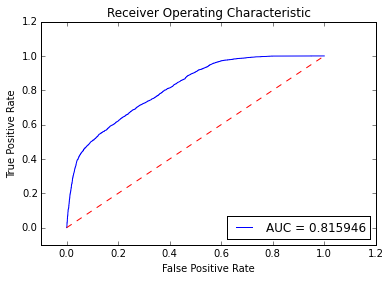

In [118]:
# plot ROC
lgr_fpr, lgr_tpr, thresholds = roc_curve(y_test, lgr_predicted_prob)
lgr_roc_auc = auc(lgr_fpr, lgr_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(lgr_fpr, lgr_tpr, 'b',
label='AUC = %f'% lgr_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [119]:
print "Total processing time: %s sec"%(time.time() - start)

Total processing time: 914.895545959 sec


In [126]:
lgr_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('clf', LogisticRegression(penalty='l1')),
])

In [127]:
lgr_text_clf = lgr_text_clf.fit(X_train, y_train)

In [128]:
# test
lgr_predicted_prob = lgr_text_clf.predict_proba(X_test)[:,1]
lgr_predicted = lgr_text_clf.predict(X_test)

print 'Accuracy:'
print np.mean(lgr_predicted == y_test)
print(metrics.classification_report(y_test, lgr_predicted,
    target_names=['Washington', 'Massachusetts']))

metrics.confusion_matrix(y_test, lgr_predicted)

Accuracy:
0.725813975184
               precision    recall  f1-score   support

   Washington       0.69      0.91      0.79      5995
Massachusetts       0.81      0.49      0.61      4724

  avg / total       0.75      0.73      0.71     10719



array([[5458,  537],
       [2402, 2322]])

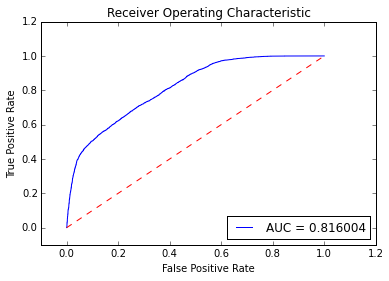

In [129]:
# plot ROC
lgr_fpr, lgr_tpr, thresholds = roc_curve(y_test, lgr_predicted_prob)
lgr_roc_auc = auc(lgr_fpr, lgr_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(lgr_fpr, lgr_tpr, 'b',
label='AUC = %f'% lgr_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 7) Sentiment Analysis

In [10]:
from textblob import TextBlob
import re
def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [11]:
f = open('tweet_data/tweets_#gopatriots.txt')

# Make sure to go back to file head
f_start = f.tell()
f.seek(f_start)
tweets = []
for line in f.readlines():
    tweet = json.loads(line)
    obj = {}
    obj['loc'] = tweet['tweet']['user']['location']
    obj['text'] = tweet['tweet']['text']
    obj['sentiment'] = get_tweet_sentiment(tweet['tweet']['text'])
    
    tweets.append(obj)
print "#gopatriots loaded"

#gopatriots loaded


In [30]:
# picking positive tweets from tweets
ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
# percentage of positive tweets
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets)))

# picking negative tweets from tweets
ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))

# percentage of neutral tweets
print("Neutral tweets percentage: {} %".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets)))

# percentage of positive/negative tweets in MA
WA = ['Washington', 'WA','Seattle','Kirkland'] 
MA = ['Massachusetts','MA','Boston'] 

tweets_MA = [tweet for tweet in tweets if any(x in tweet['loc'] for x in MA)]
tweets_not_MA = [tweet for tweet in tweets if not any(x in tweet['loc'] for x in MA)]
tweets_WA = [tweet for tweet in tweets if any(x in tweet['loc'] for x in WA)]
print len(tweets_MA)
print len(tweets_not_MA)
print ("Tweets in MA")
pMAtweets = [tweet for tweet in tweets_MA if tweet['sentiment'] == 'positive']
print("Positive tweets percentage: {} %".format(100*len(pMAtweets)/len(tweets_MA)))

nMAtweets = [tweet for tweet in tweets_MA if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(nMAtweets)/len(tweets_MA)))

print ("Tweets in WA")
pWAtweets = [tweet for tweet in tweets_WA if tweet['sentiment'] == 'positive']
print("Positive tweets percentage: {} %".format(100*len(pWAtweets)/len(tweets_WA)))

nWAtweets = [tweet for tweet in tweets_WA if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(nWAtweets)/len(tweets_WA)))

print ("Tweets not in MA")
pNMAtweets = [tweet for tweet in tweets_not_MA if tweet['sentiment'] == 'positive']
print("Positive tweets percentage: {} %".format(100*len(pNMAtweets)/len(tweets_not_MA)))

nNMAtweets = [tweet for tweet in tweets_not_MA if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(nNMAtweets)/len(tweets_not_MA)))

Positive tweets percentage: 23 %
Negative tweets percentage: 8 %
Neutral tweets percentage: 67 %
1259
24973
Tweets in MA
Positive tweets percentage: 32 %
Negative tweets percentage: 14 %
Tweets in WA
Positive tweets percentage: 33 %
Negative tweets percentage: 17 %
Tweets not in MA
Positive tweets percentage: 23 %
Negative tweets percentage: 8 %


In [37]:
# printing first 5 positive tweets
print("\n\nPositive tweets:")
for tweet in pWAtweets[:10]:
    print(tweet['text'])

# printing first 5 negative tweets
print("\n\nNegative tweets:")
for tweet in nWAtweets[:10]:
    print(tweet['text'])



Positive tweets:
Will be so glad when this shift is over. So ready for the weekend #HomeDepot #GoPatriots
Oh, okay. #GoHawks 
But #GoPatriots too. @ Seattle Downtown http://t.co/Oi0fusmFLP
Good Sunday morning! #GoPatriots
@KenB_Sr Aww, thanks, Ken! Rootin' for the Pats even if I know diddly squat about football. #GoPatriots
@bibbsmike good news for you is I'm closer to 40 than you are! And re: the Patriots...you don't like "pink hat" fans? #GoPatriots
Way to go Seahawks! You won't be so fortunate against the New England Patriots! #GoPatriots!
Let's go New England Patriots! #GoPatriots!
Still stunned by that #Seahawks victory!! Wow!! Now time for the #Patriots to join them! #GoPatriots
Oh yeah. I'm liking the beginning of this game *much* better. #GoPatriots
And there we have it! It will be the New England Patriots vs the Seahawks in the latest Superbowl! #GoPatriots!


Negative tweets:
So can't wait for the game tomorrow. The #Patriots game that is. #GoPatriots
@PaulNanos sorry to di

In [16]:
f = open('tweet_data/tweets_#gohawks.txt')

# Make sure to go back to file head
f_start = f.tell()
f.seek(f_start)
tweets_hawks = []
for line in f.readlines():
    tweet = json.loads(line)
    obj = {}
    obj['loc'] = tweet['tweet']['user']['location']
    obj['text'] = tweet['tweet']['text']
    obj['sentiment'] = get_tweet_sentiment(tweet['tweet']['text'])
    
    tweets_hawks.append(obj)
print "#gohawks loaded"

#gohawks loaded


In [29]:
# picking positive tweets from tweets
ptweets = [tweet for tweet in tweets_hawks if tweet['sentiment'] == 'positive']
# percentage of positive tweets
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets_hawks)))

# picking negative tweets from tweets
ntweets = [tweet for tweet in tweets_hawks if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets_hawks)))

# picking neutral tweets from tweets
nntweets = [tweet for tweet in tweets_hawks if tweet['sentiment'] == 'neutral']

# percentage of neutral tweets
print("Neutral tweets percentage: {} %".format(100*(len(tweets_hawks) - len(ntweets) - len(ptweets))/len(tweets_hawks)))

tweets_MA = [tweet for tweet in tweets_hawks if any(x in tweet['loc'] for x in MA)]
tweets_not_WA = [tweet for tweet in tweets_hawks if not any(x in tweet['loc'] for x in WA)]
tweets_WA = [tweet for tweet in tweets_hawks if any(x in tweet['loc'] for x in WA)]
print len(tweets_MA)
print len(tweets_WA)
print len(tweets_not_WA)
print ("Tweets in MA")
pMAtweets = [tweet for tweet in tweets_MA if tweet['sentiment'] == 'positive']
print("Positive tweets percentage: {} %".format(100*len(pMAtweets)/len(tweets_MA)))

nMAtweets = [tweet for tweet in tweets_MA if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(nMAtweets)/len(tweets_MA)))

print ("Tweets in WA")
pWAtweets = [tweet for tweet in tweets_WA if tweet['sentiment'] == 'positive']
print("Positive tweets percentage: {} %".format(100*len(pWAtweets)/len(tweets_WA)))

nWAtweets = [tweet for tweet in tweets_WA if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(nWAtweets)/len(tweets_WA)))

print ("Tweets not in WA")
pNMAtweets = [tweet for tweet in tweets_not_WA if tweet['sentiment'] == 'positive']
print("Positive tweets percentage: {} %".format(100*len(pNMAtweets)/len(tweets_not_WA)))

nNMAtweets = [tweet for tweet in tweets_not_WA if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(nNMAtweets)/len(tweets_not_WA)))

Positive tweets percentage: 34 %
Negative tweets percentage: 13 %
Neutral tweets percentage: 51 %
563
57339
130797
Tweets in MA
Positive tweets percentage: 37 %
Negative tweets percentage: 16 %
Tweets in WA
Positive tweets percentage: 37 %
Negative tweets percentage: 13 %
Tweets not in WA
Positive tweets percentage: 33 %
Negative tweets percentage: 13 %


In [38]:
# printing first 5 positive tweets
print("\n\nPositive tweets:")
for tweet in ptweets[:10]:
    print(tweet['text'])

# printing first 5 negative tweets
print("\n\nNegative tweets:")
for tweet in ntweets[:10]:
    print(tweet['text'])



Positive tweets:
I don't care what anyone says! Tom Brady is the best ever!! #GoPatriots
The girls soccer team is ranked the No. 3 team in the state. Full rankings: http://t.co/9Tw8iToZHl #GoPatriots.
@christinaballin thanks for the follow! 
#GoPatriots
“@_ria84: @JoshJenkins24 which team do you follow? who do you want to win Super Bowl XLIX??” Stay tuned for next weeks column #GoPatriots 🏈
Reminder - Old HomeBase Bell Schedule today/tomorrow Patriots for scheduling meetings. Freshmen today; Sophomores tomorrow. #gopatriots
Can't wait to watch the Super Bowl of this season😍😍 I swear I'll not going to miss it this time! #GoPatriots
@MP_DESIGNS_Bx Thanks Great day to you too brotha!! #PatriotsFamily #GoPatriots
@honeychocolate9 You too!! Only 4 more days until  #Gameday #GoPatriots
Beautiful man, beautiful numbers! #GoPatriots #BradyIsBetter #AFCChampionship http://t.co/KSHhRR2zzA
@honeychocolate9 Of course I'm ready. #GoPatriots


Negative tweets:
LeGarrette Blount does the Ray Lewis 